# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on VMPO cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os, wget

import cupy as cp
import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

In [2]:
import rmm

rmm.reinitialize(managed_memory=True)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

## Set parameters

In [3]:
def download_file(url,dir,download_file):
    ext=download_file.split(".")[-1]
    if ext=="gz":
        is_gz=True   
    if is_gz:
        input_file=os.path.join(dir,download_file.replace(".gz",""))
    else:
        input_file=download_file

    if not os.path.exists(os.path.join(dir,input_file)):
        print('Downloading %s'%download_file)
        os.makedirs(dir, exist_ok=True)
        wget.download(url,os.path.join(dir,download_file))

In [5]:
url_list=[r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5920431&format=file&file=GSM5920431%5FVMPO%5FSAL%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5920431&format=file&file=GSM5920431%5FVMPO%5FSAL%5Fgenes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5920431&format=file&file=GSM5920431%5FVMPO%5FSAL%5Fmatrix%2Emtx%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5920430&format=file&file=GSM5920430%5FVMPO%5FLPS%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5920430&format=file&file=GSM5920430%5FVMPO%5FLPS%5Fgenes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5920430&format=file&file=GSM5920430%5FVMPO%5FLPS%5Fmatrix%2Emtx%2Egz"]

dir="../data/mouse_VMPO/"
file_list=["GSM5920431_VMPO_SAL_barcodes.tsv.gz","GSM5920431_VMPO_SAL_genes.tsv.gz",
"GSM5920431_VMPO_SAL_matrix.mtx.gz","GSM5920430_VMPO_LPS_barcodes.tsv.gz",
"GSM5920430_VMPO_LPS_genes.tsv.gz","GSM5920430_VMPO_LPS_matrix.mtx.gz"]

for idx,url in enumerate(url_list):
    download_file(url,dir,file_list[idx])

KeyboardInterrupt: 

In [6]:
from sh import gunzip
for file in file_list:
    gunzip(os.path.join(dir,file))


In [4]:
dir="../data/mouse_VMPO/"
adata = sc.read_10x_mtx(os.path.join(dir,"GSM5920431_VMPO_SAL/"),prefix="GSM5920431_VMPO_SAL_")
print(adata.X.shape)
adata.obs["exp_group"]="SAL"

(6780, 27998)


In [5]:
adata2 = sc.read_10x_mtx(os.path.join(dir,"GSM5920430_VMPO_LPS/"),prefix="GSM5920430_VMPO_LPS_")
print(adata2.X.shape)
adata2.obs["exp_group"]="LPS"

(9647, 27998)


In [6]:
adata=anndata.concat([adata,adata2])
adata.obs_names_make_unique
del adata2

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [11]:
print(adata.shape)

(16427, 27998)


In [7]:
drug_receptor_mtx=pd.read_csv("../data/Antipsychotics/drug_receptor_mtx.csv")
GPCR_df=pd.read_csv("../data/Antipsychotics/GPCR_df.csv")

In [8]:
print(drug_receptor_mtx.columns)
d_r_column=drug_receptor_mtx.columns
d_r_column_rep=['Ligand',"HTR1A","HTR1B","HTR1D","HTR1E","HTR2A","HTR2B","HTR2C",
"HTR3A","HTR4","HTR5A","HTR6","HTR7","DRD1","DRD2","DRD3","DRD4","DRD5",
"HRH1","HRH2","HRH3","CHRM1","CHRM2","CHRM3","CHRM4","CHRM5",
"ADRA1A","ADRA1B","ADRA2A","ADRA2B","ADRA2C","ADRB1","ADRB2"]

drug_receptor_mtx.columns=d_r_column_rep
drug_receptor_mtx=drug_receptor_mtx.set_index("Ligand")
D_R_mtx=drug_receptor_mtx
#print(drug_receptor_mtx.columns)

Index(['Ligand', '5-HT1A', '5-HT1B', '5-HT1D', '5-HT1E', '5-HT2A', '5-HT2B',
       '5-HT2C', '5-HT3', '5-HT4', '5-HT5', '5HT6', '5HT7', 'D1', 'D2', 'D3',
       'D4', 'D5', 'H1', 'H2', 'H3', 'M1', 'M2', 'M3', 'M4', 'M5', 'alpha1A',
       'alpha1B', 'alpha2A', 'alpha2B', 'alpha2C', 'beta1', 'beta2'],
      dtype='object')


In [9]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["CX3CR1","CLDN5","GLUL","NDRG2","PCDH15","PLP1","MBP","SATB2","SLC17A7",
"SLC17A6","GAD2","GAD1","SNAP25"] # Marker genes for visualization
#print(d_r_column_rep[1:])
markers.extend(d_r_column_rep[1:])
markers = [str.upper() for str in markers]
markers.remove("HTR1E")
# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# Batched PCA
pca_train_ratio = 0.35 # percentage of cells to use for PCA training
n_pca_batches = 10

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

In [10]:
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)
#(sparse_gpu_array, min_genes=min_genes_per_cell, max_genes=max_genes_per_cell)
df_exp_group=adata.obs["exp_group"]



Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


## Load and Preprocess Data

We load the sparse count matrix from an `csv` file using Scanpy. 

In [92]:
preprocess_start = time.time()

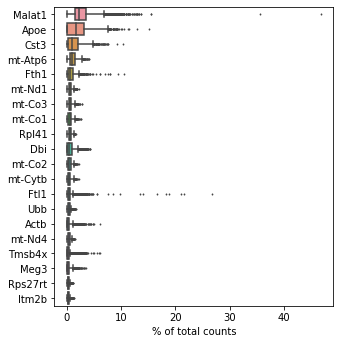

In [90]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [11]:
genes = cudf.Series(adata.var_names).str.upper()
print(genes)
from scipy import sparse

sparse_X = sparse.csr_matrix(adata.X)
adata.X = sparse_X
sparse_gpu_array = cp.sparse.csr_matrix(adata.X)

0                  XKR4
1                GM1992
2               GM37381
3                   RP1
4                 RP1-1
              ...      
27993        AC168977.1
27994              PISD
27995             DHRSX
27996          VMN2R122
27997    CAAA01147332.1
Length: 27998, dtype: object


Verify the shape of the resulting sparse matrix:

In [48]:
sparse_gpu_array.shape

(7745, 22414)

And the number of non-zero values in the matrix:

In [49]:
sparse_gpu_array.nnz

23652681

In [12]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.filter_cells(sparse_gpu_array, min_genes=min_genes_per_cell, max_genes=max_genes_per_cell)

CPU times: user 201 ms, sys: 109 ms, total: 309 ms
Wall time: 308 ms


Some genes will now have zero expression in all cells. We filter out such genes.

In [13]:
%%time
sparse_gpu_array, genes = rapids_scanpy_funcs.filter_genes(sparse_gpu_array, genes, min_cells=min_cells_per_gene)

CPU times: user 226 ms, sys: 36.3 ms, total: 263 ms
Wall time: 261 ms


The size of our count matrix is now reduced.

In [35]:
sparse_gpu_array.shape

(16427, 21653)

In [36]:
len(genes)

21653

In [37]:
print(len(df_exp_group))

16427


In [14]:
import pandas as pd
df=genes.to_pandas()
#print(df)
#df.to_csv("../data/SFO/genes.csv")
for marker in markers:
    if not marker in df.values:
        print("%s is not included"%marker)
        markers.remove(marker)
        print("%s is removed from marker list"%marker)

In [15]:
%%time
tmp_norm = sparse_gpu_array.tocsc()
marker_genes_raw = {
    ("%s_raw" % marker): tmp_norm[:, genes[genes == marker].index[0]].todense().ravel()
    for marker in markers
}

del tmp_norm

CPU times: user 389 ms, sys: 92.3 ms, total: 481 ms
Wall time: 478 ms


### Regress out confounding factors (number of counts, mitochondrial gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of mitochondrial genes (named starting with `mt-`).

We now calculate the total counts and the percentage of mitochondrial counts for each cell.

In [16]:
%%time
mito_genes = genes.str.startswith(MITO_GENE_PREFIX)

n_counts = sparse_gpu_array.sum(axis=1)
percent_mito = (sparse_gpu_array[:,mito_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_mito = cp.array(percent_mito).ravel()

CPU times: user 20.3 ms, sys: 351 µs, total: 20.6 ms
Wall time: 18.3 ms


In [17]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'exp_group' as categorical


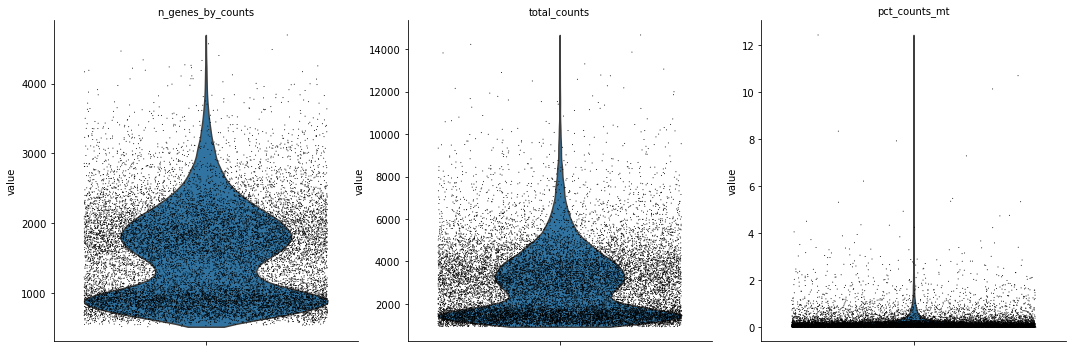

In [18]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

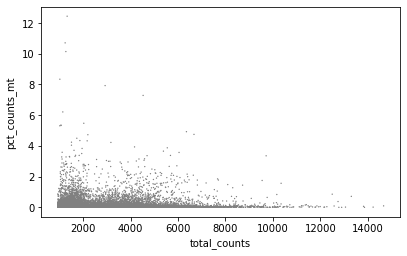

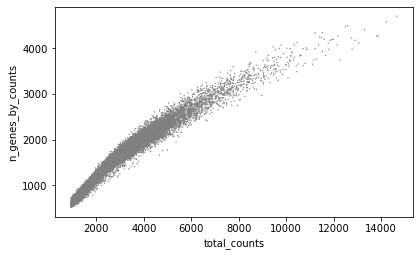

In [19]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

And perform regression:

In [20]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.regress_out(sparse_gpu_array.tocsc(), n_counts, percent_mito)
del n_counts, percent_mito, mito_genes

CPU times: user 3min 33s, sys: 38.6 s, total: 4min 11s
Wall time: 4min 11s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [21]:
%%time
mean = sparse_gpu_array.mean(axis=0)
sparse_gpu_array -= mean
stddev = cp.sqrt(sparse_gpu_array.var(axis=0))
sparse_gpu_array /= stddev
sparse_gpu_array = sparse_gpu_array.clip(a_max=10)
del mean, stddev

CPU times: user 205 ms, sys: 67.4 ms, total: 272 ms
Wall time: 270 ms


## Cluster & Visualize

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [23]:
%%time
adata = anndata.AnnData(sparse_gpu_array.get())
adata.var_names = genes.to_pandas()
del sparse_gpu_array, genes
#adata.obs["exp_group"]=df_exp_group

NameError: name 'sparse_gpu_array' is not defined

In [24]:
%%time
for name, data in marker_genes_raw.items():
    adata.obs[name] = data.get()

CPU times: user 28.8 ms, sys: 20.2 ms, total: 49 ms
Wall time: 48.1 ms


### Calculate Antipsychotics response

In [25]:
drug_list=drug_receptor_mtx.index.to_list()

Gs=GPCR_df[GPCR_df.type=="Gs"]["receptor_name"]
Gi=GPCR_df[GPCR_df.type=="Gi"]["receptor_name"]
Gq=GPCR_df[GPCR_df.type=="Gq"]["receptor_name"]

In [26]:
#D_R_mtx=pd.read_csv("../data/Antipsychotics/drug_receptor_mtx.csv")
GPCR_type_df=pd.read_csv("../data/Antipsychotics/GPCR_df.csv")

In [27]:
GPCR_list=d_r_column_rep[1:]

In [28]:
%%time
GPCR_df=pd.DataFrame()
for name, data in marker_genes_raw.items():
    adata.obs[name] = data.get()
    if   name[:-4] in GPCR_list:
        GPCR_df[name]=data.get()

CPU times: user 30.7 ms, sys: 484 µs, total: 31.2 ms
Wall time: 29.5 ms


In [29]:
GPCR_adata=anndata.AnnData(X=GPCR_df)
#print(GPCR_adata.X.shape)
GPCR_adata.obs=pd.DataFrame(GPCR_df.index)
GPCR_adata.var=pd.DataFrame(GPCR_df.columns)

In [30]:
GPCR_adata_norm=sc.pp.normalize_total(GPCR_adata,target_sum=1e4,inplace=False)['X']

In [31]:
norm_df=pd.DataFrame(GPCR_adata_norm)
norm_col=[str[:-4] for str in GPCR_df.columns]
#print(norm_col)
norm_df.columns=norm_col
print(norm_df)

       HTR1A  HTR1B  HTR1D  HTR2A  HTR2B        HTR2C  HTR3A     HTR4  HTR5A  \
0        0.0    0.0    0.0    0.0    0.0     0.000000    0.0      0.0    0.0   
1        0.0    0.0    0.0    0.0    0.0     0.000000    0.0      0.0    0.0   
2        0.0    0.0    0.0    0.0    0.0     0.000000    0.0      0.0    0.0   
3        0.0    0.0    0.0    0.0    0.0     0.000000    0.0      0.0    0.0   
4        0.0    0.0    0.0    0.0    0.0     0.000000    0.0      0.0    0.0   
...      ...    ...    ...    ...    ...          ...    ...      ...    ...   
16422    0.0    0.0    0.0    0.0    0.0  1999.999878    0.0      0.0    0.0   
16423    0.0    0.0    0.0    0.0    0.0     0.000000    0.0      0.0    0.0   
16424    0.0    0.0    0.0    0.0    0.0  7500.000000    0.0      0.0    0.0   
16425    0.0    0.0    0.0    0.0    0.0  5000.000000    0.0   5000.0    0.0   
16426    0.0    0.0    0.0    0.0    0.0     0.000000    0.0  10000.0    0.0   

       HTR6  ...    CHRM3  CHRM4  CHRM5

In [39]:
print(norm_col)

['HTR1A', 'HTR1B', 'HTR1D', 'HTR2A', 'HTR2B', 'HTR2C', 'HTR3A', 'HTR4', 'HTR5A', 'HTR6', 'HTR7', 'DRD1', 'DRD2', 'DRD3', 'DRD5', 'HRH1', 'HRH2', 'HRH3', 'CHRM1', 'CHRM2', 'CHRM3', 'ADRA1A', 'ADRA1B', 'ADRA2A', 'ADRA2B', 'ADRA2C', 'ADRB1', 'ADRB2']


In [32]:
print(GPCR_type_df[GPCR_type_df.receptor_name.isin(norm_col)])
GPCR_type_df=GPCR_type_df[GPCR_type_df.receptor_name.isin(norm_col)]

    Unnamed: 0 receptor_name type
0            0        ADRA1A   Gq
1            1        ADRA1B   Gq
2            2        ADRA2A   Gi
3            3        ADRA2B   Gi
4            4        ADRA2C   Gi
5            5         ADRB1   Gs
6            6         ADRB2   Gs
7            7         CHRM1   Gq
8            8         CHRM2   Gi
9            9         CHRM3   Gq
10          10         CHRM4   Gi
11          11         CHRM5   Gq
12          12          DRD1   Gs
13          13          DRD2   Gi
14          14          DRD3   Gi
15          15          DRD4   Gi
16          16          DRD5   Gs
17          17          HRH1   Gq
18          18          HRH2   Gs
19          19          HRH3   Gi
20          20         HTR1A   Gi
21          21         HTR1B   Gi
22          22         HTR1D   Gi
24          24         HTR2A   Gq
25          25         HTR2B   Gq
26          26         HTR2C   Gq
27          27          HTR4   Gs
28          28          HTR6   Gs
29          29

In [33]:
Gs=GPCR_type_df[GPCR_type_df.type=="Gs"]["receptor_name"].values
Gi=GPCR_type_df[GPCR_type_df.type=="Gi"]["receptor_name"].values
Gq=GPCR_type_df[GPCR_type_df.type=="Gq"]["receptor_name"].values

#print(Gs)
#print(GPCR_adata_norm)
drug_list=D_R_mtx.index.to_list()
print(drug_list)
#drug_receptor_mtx
cAMP_df=pd.DataFrame(columns=drug_list)
Ca_df=pd.DataFrame(columns=drug_list)
for drug in drug_list:
    Gs_effect=(norm_df.loc[:,Gs]/D_R_mtx.loc[drug,Gs]).sum(axis=1) #TODO ki値で割り算するときにlog換算すべきか
    Gi_effect=(norm_df.loc[:,Gi]/D_R_mtx.loc[drug,Gi]).sum(axis=1)
    Gq_effect=(norm_df.loc[:,Gq]/D_R_mtx.loc[drug,Gq]).sum(axis=1)
    cAMPmod=Gi_effect-Gs_effect #Giの阻害→cAMP上昇、Gsの阻害→cAMP低下
    Camod=-Gq_effect #Gq阻害→Ca低下
    cAMP_df[drug]=cAMPmod
    Ca_df[drug]=Camod

['CHLORPROMAZINE', 'FLUPHENAZINE', 'HALOPERIDOL', 'ZOTEPINE', 'RISPERIDONE', 'Quetiapine', 'ARIPIPRAZOLE', 'OLANZAPINE', 'CLOZAPINE']


In [34]:
cAMP_df.index=adata.obs_names
Ca_df.index=adata.obs_names
Ca_df=Ca_df+10**(-4)
for drug in drug_list:
    adata.obs['cAMP_%s'%drug]=cAMP_df[drug]
    adata.obs['Ca_%s'%drug]=Ca_df[drug]

### UMAP + Graph clustering

We can also visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

Note that Scanpy uses an approximation to the nearest neighbors on the CPU while the GPU version performs an exact search. While both methods are known to yield useful results, some differences in the resulting visualization and clusters can be observed.

In [35]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

         Falling back to preprocessing with `sc.pp.pca` and default params.
CPU times: user 3min 55s, sys: 21.8 s, total: 4min 17s
Wall time: 17.4 s


The UMAP function from Rapids is also integrated into Scanpy.

In [36]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

CPU times: user 86 ms, sys: 124 ms, total: 210 ms
Wall time: 208 ms


Next, we use the Louvain algorithm for graph-based clustering.

In [37]:
%%time
sc.tl.louvain(adata, flavor='rapids')

CPU times: user 49 ms, sys: 7.45 ms, total: 56.5 ms
Wall time: 54.9 ms


We plot the cells using the UMAP visualization, and using the Louvain clusters as labels.

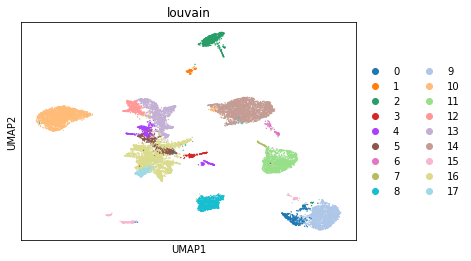

CPU times: user 344 ms, sys: 497 µs, total: 344 ms
Wall time: 340 ms


In [38]:
%%time
sc.pl.umap(adata, color=["louvain"])

We can also use the Leiden clustering method in RAPIDS. This method has not been integrated into Scanpy and needs to be called separately.

In [39]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

CPU times: user 36.8 ms, sys: 11 ms, total: 47.8 ms
Wall time: 46.1 ms


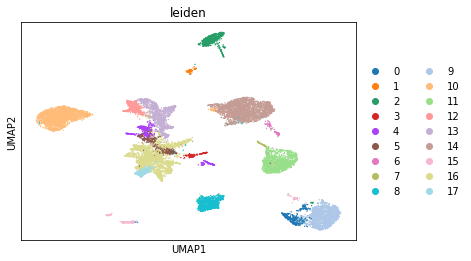

CPU times: user 345 ms, sys: 8.12 ms, total: 353 ms
Wall time: 351 ms


In [40]:
%%time
sc.pl.umap(adata, color=["leiden"])

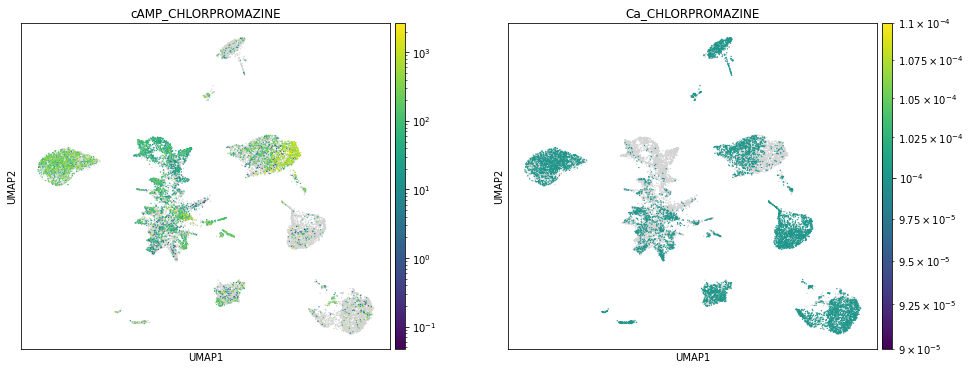

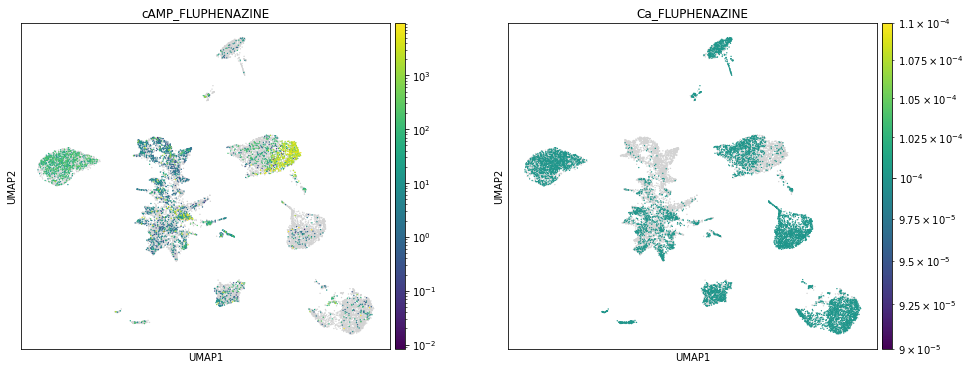

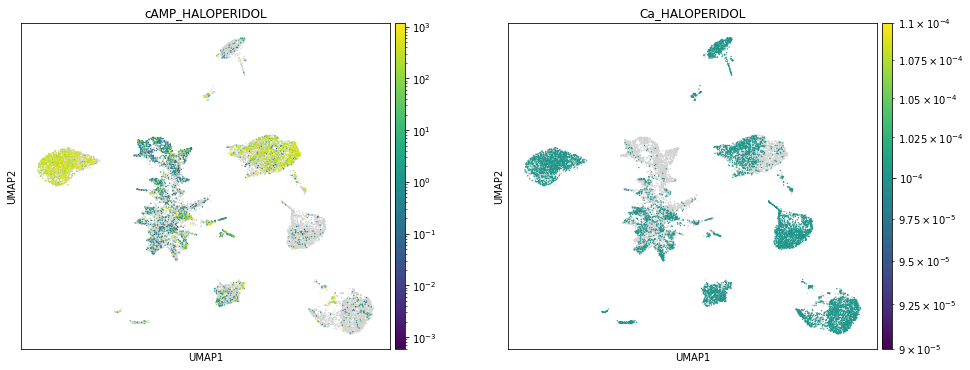

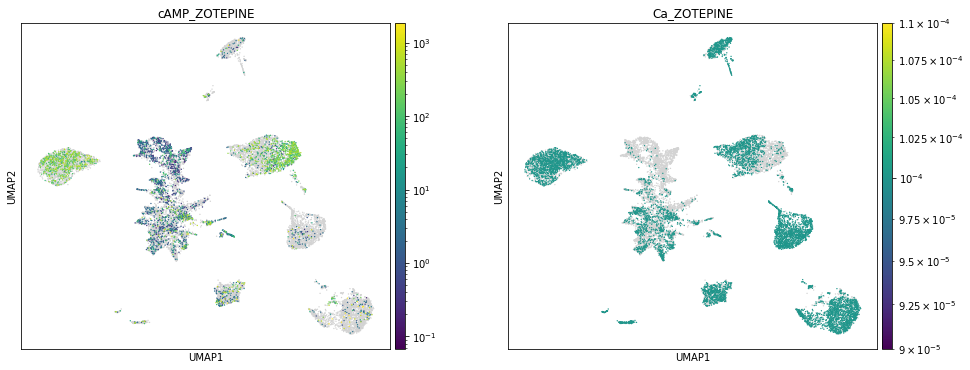

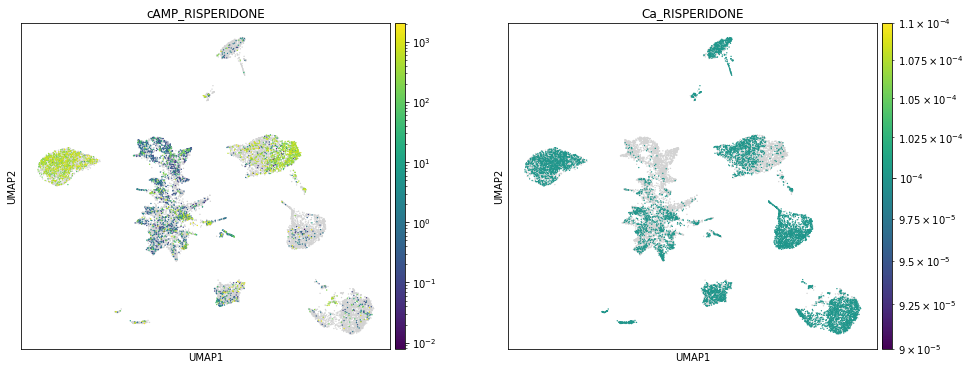

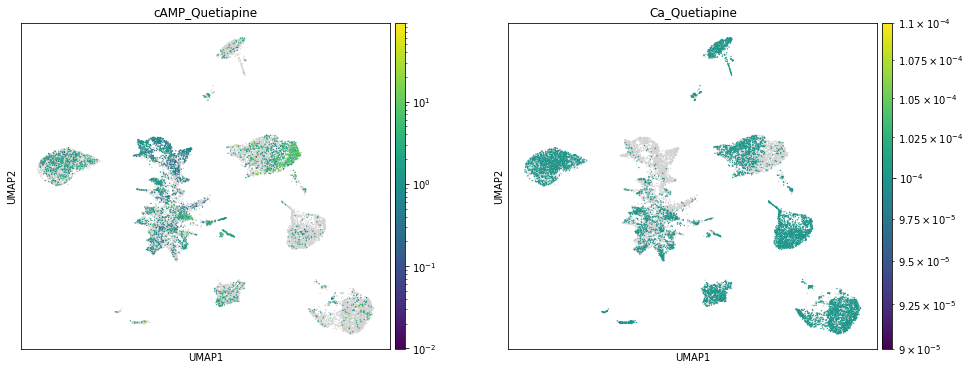

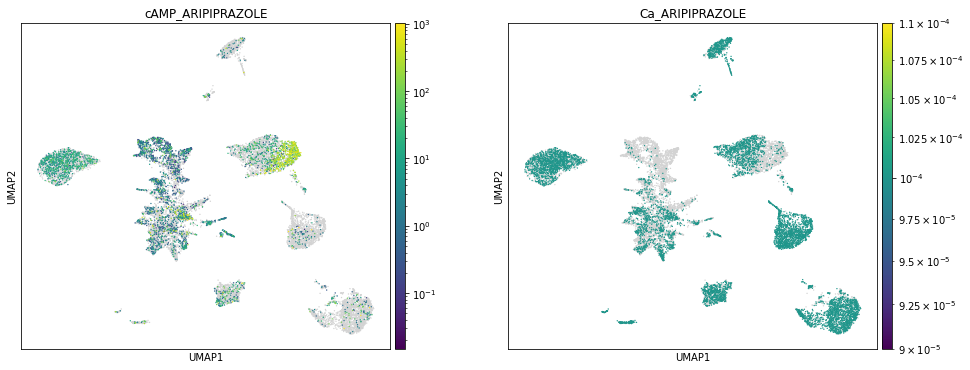

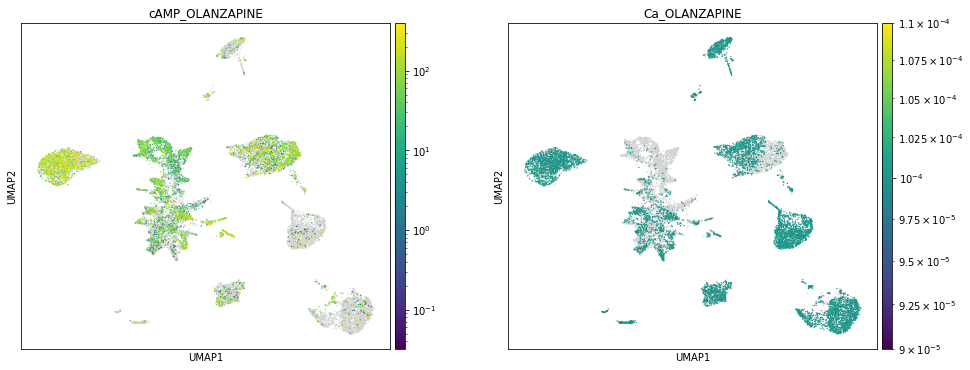

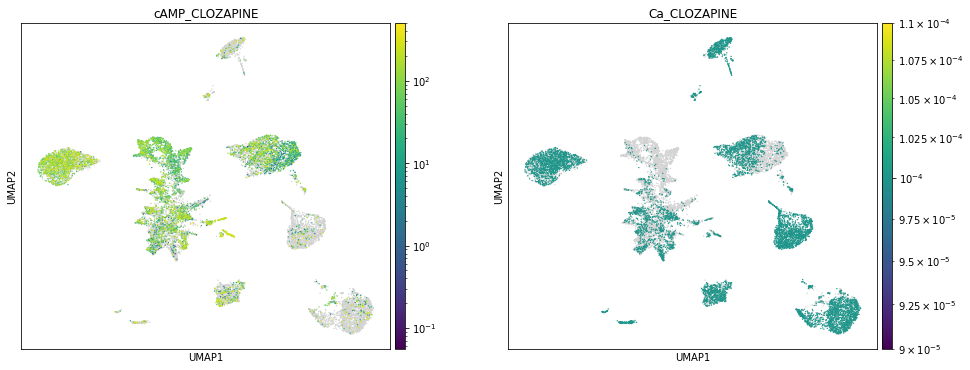

In [41]:
for drug in drug_list:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), gridspec_kw={'wspace':0.2})
    ax1_dict = sc.pl.umap(adata, color=["cAMP_%s"%drug],norm=LogNorm(),ax=ax1, show=False)
    ax2_dict = sc.pl.umap(adata, color=["Ca_%s"%drug],norm=LogNorm(),ax=ax2, show=False)

And we can visualize the cells labeled by expression of the `Stmn2` and `Hes1` marker genes, for neuronal and glial cells respectively.

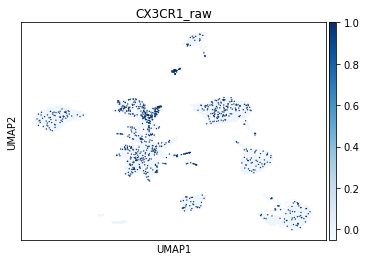

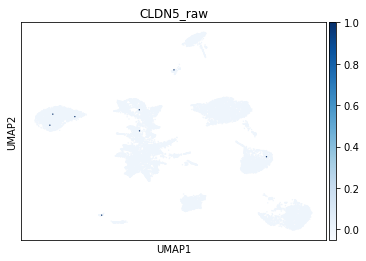

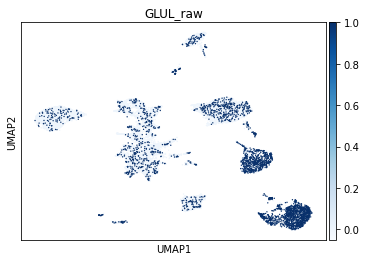

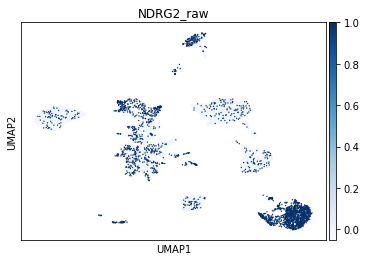

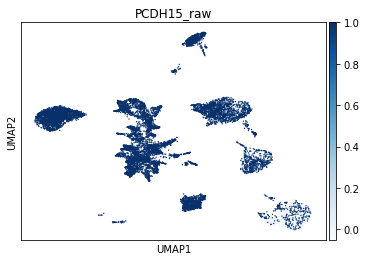

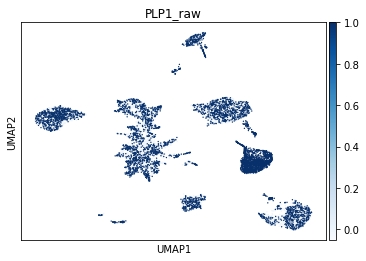

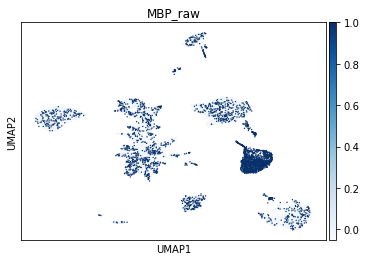

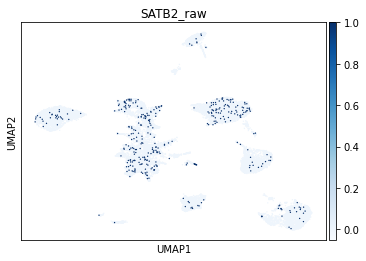

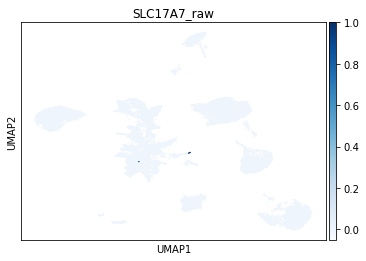

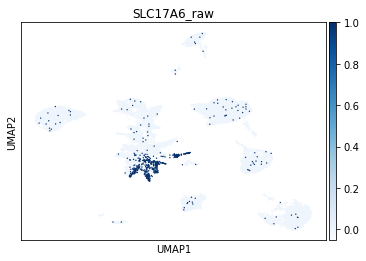

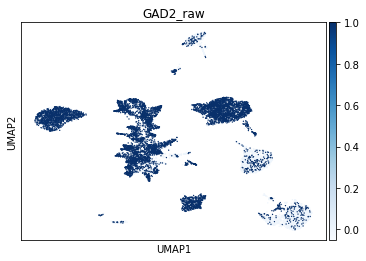

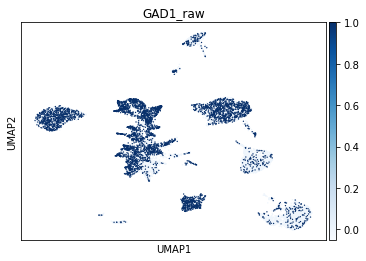

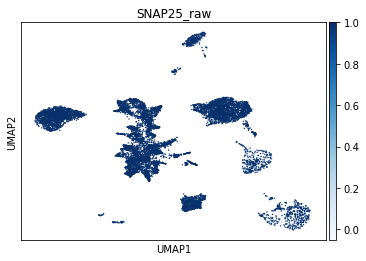

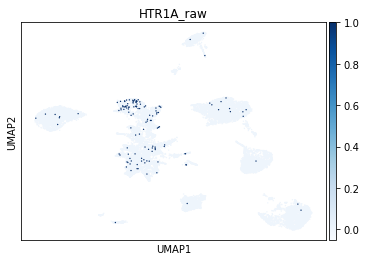

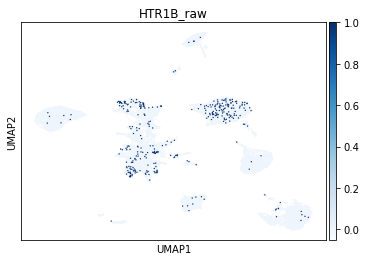

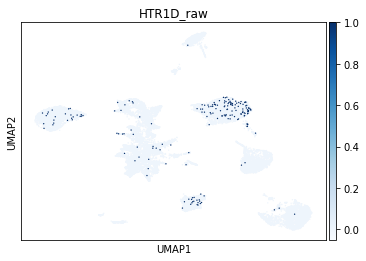

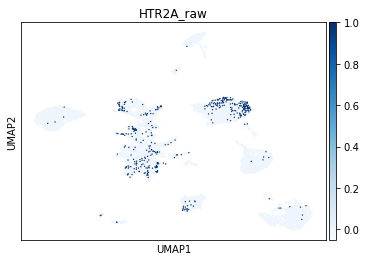

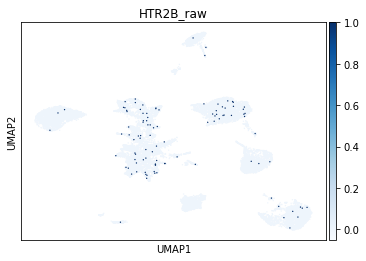

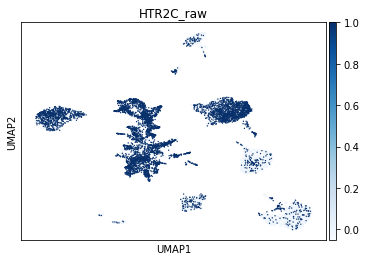

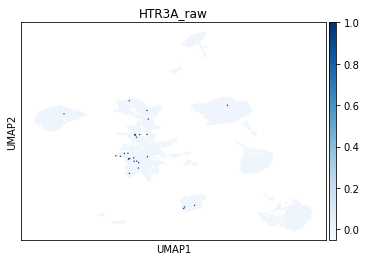

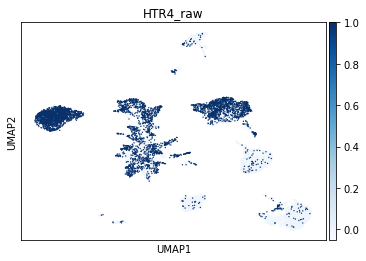

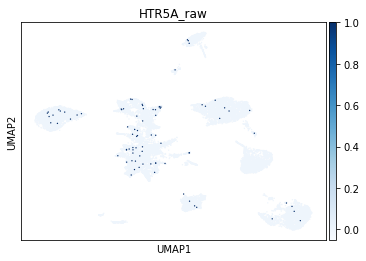

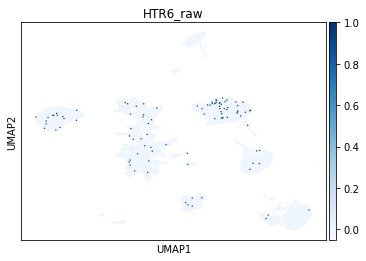

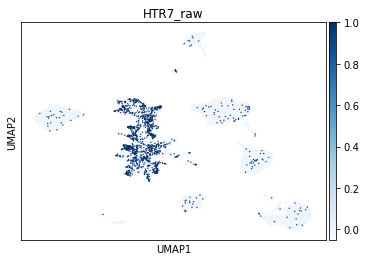

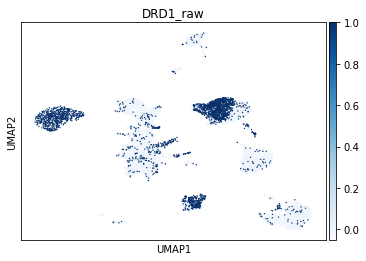

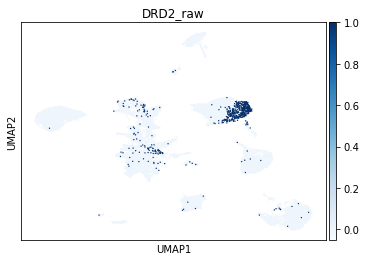

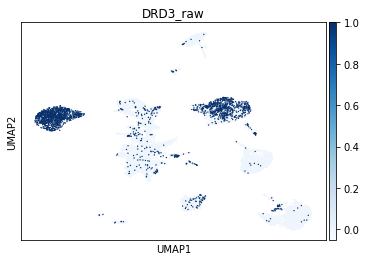

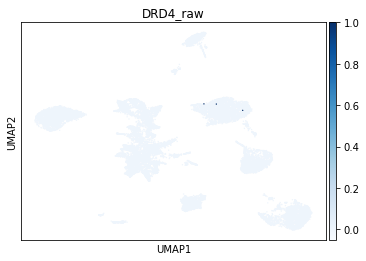

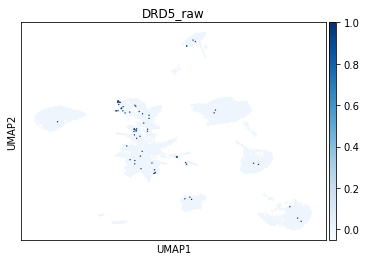

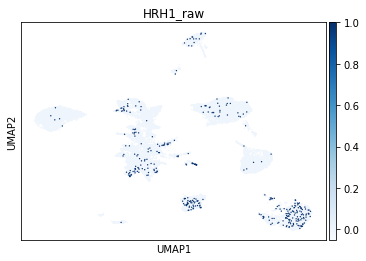

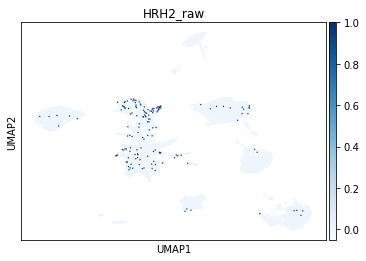

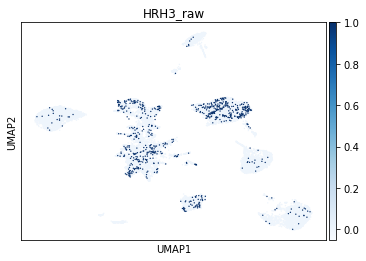

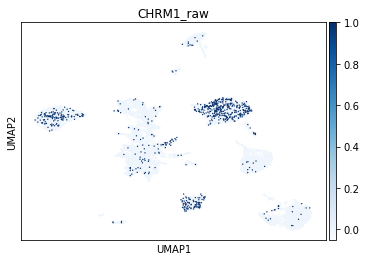

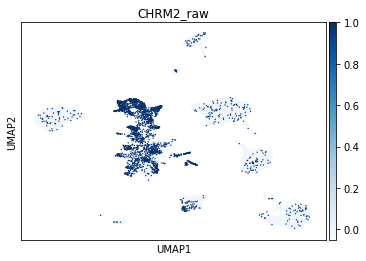

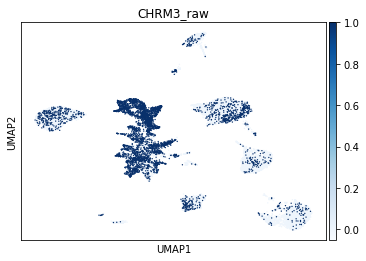

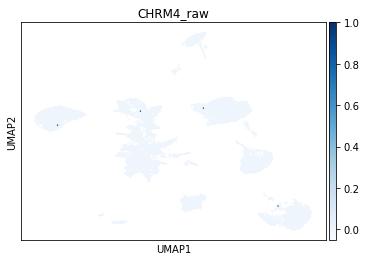

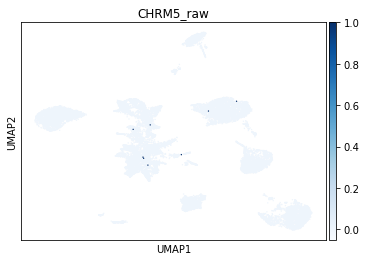

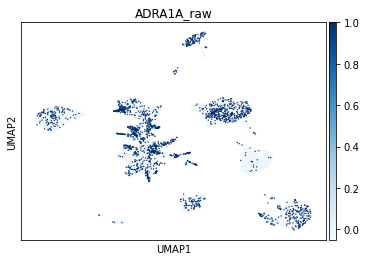

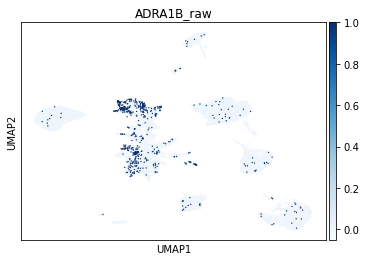

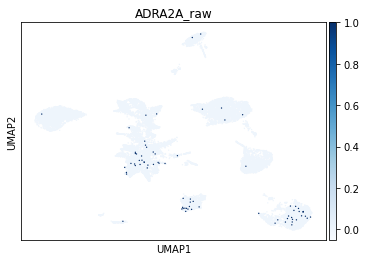

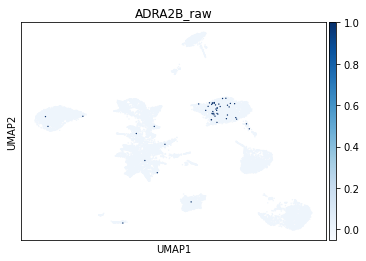

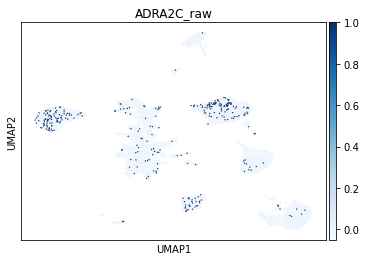

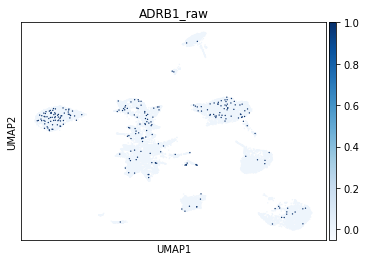

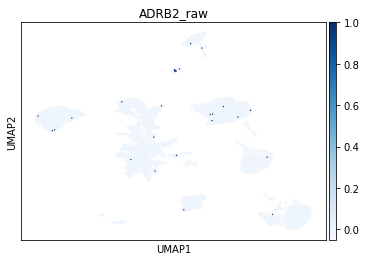

CPU times: user 5.74 s, sys: 73.7 ms, total: 5.81 s
Wall time: 5.76 s


In [42]:
%%time
for marker in markers:
    sc.pl.umap(adata, color=["%s_raw"%marker], color_map="Blues", vmax=1, vmin=-0.05)

In [43]:
dir="../data/mouse_VMPO/"
h5_fname=os.path.join(dir,"mouse_VMPO_adata.h5ad")
adata.write(filename=h5_fname)

In [60]:
dir="../data/mouse_VMPO/"
h5_fname=os.path.join(dir,"mouse_VMPO_adata.h5ad")
adata=sc.read_h5ad(h5_fname)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [61]:
adata.obs["clz_olz_ratio"]=adata.obs["cAMP_CLOZAPINE"]/adata.obs["cAMP_OLANZAPINE"]

In [62]:
adata.obs["is_clz_activated"]=np.zeros(len(adata.obs))
adata.obs["is_clz_activated"][adata.obs["cAMP_CLOZAPINE"]>10]=1
adata.obs["is_clz_activated"]=adata.obs["is_clz_activated"].astype("category")
print(sum(adata.obs["is_clz_activated"]))

4978.0


In [63]:
adata.obs["is_clz_inhibited"]=np.zeros(len(adata.obs))
adata.obs["is_clz_inhibited"][adata.obs["cAMP_CLOZAPINE"]<-10]=1
adata.obs["is_clz_inhibited"]=adata.obs["is_clz_inhibited"].astype("category")
print(sum(adata.obs["is_clz_inhibited"]))

1715.0


In [64]:
drug_list2=drug_list.copy()
drug_list2.remove("CLOZAPINE")
print(drug_list2)

for idx,drug in enumerate(drug_list2):
    #print(idx)
    if idx==0:
        cAMP_mean=adata.obs["cAMP_%s"%drug]
    else:
        cAMP_mean=cAMP_mean+adata.obs["cAMP_%s"%drug]
    #print(adata.obs["cAMP_%s"%drug])
cAMP_mean=cAMP_mean/len(drug_list2)
print(cAMP_mean)
adata.obs["cAMP_mean_other_than_czp"]=cAMP_mean
adata.obs["cAMP_clz_selectivity"]=adata.obs["cAMP_CLOZAPINE"]**2/cAMP_mean**2
print(sum(adata.obs["cAMP_clz_selectivity"]>1.5))

['CHLORPROMAZINE', 'FLUPHENAZINE', 'HALOPERIDOL', 'ZOTEPINE', 'RISPERIDONE', 'Quetiapine', 'ARIPIPRAZOLE', 'OLANZAPINE']
0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
            ...    
16422   -231.875440
16423      0.000000
16424      0.000000
16425    -35.694173
16426    -71.388347
Length: 16427, dtype: float64
2747


In [65]:
selectivity_threshold=1.5
adata.obs["is_clz_selective"]=np.zeros(len(adata.obs))
adata.obs["is_clz_selective"][(adata.obs["cAMP_clz_selectivity"]>1.5)&(adata.obs["cAMP_CLOZAPINE"]>0)]=1
adata.obs["is_clz_selective"]=adata.obs["is_clz_selective"].astype("category")
print(sum(adata.obs["is_clz_selective"]))

2731.0


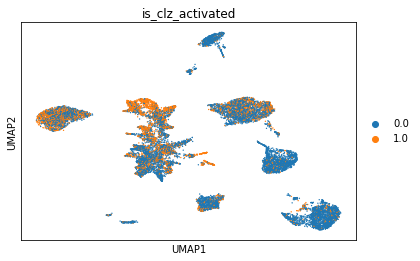

In [51]:
sc.pl.umap(adata, color=["is_clz_activated"])

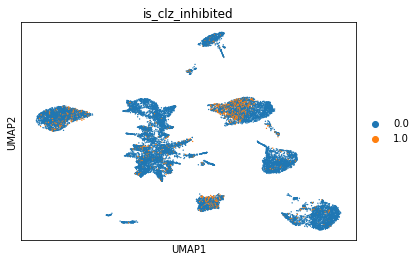

In [52]:
sc.pl.umap(adata, color=["is_clz_inhibited"])

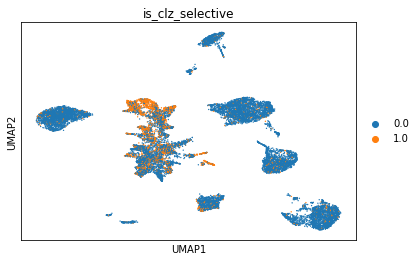

In [53]:
sc.pl.umap(adata, color=["is_clz_selective"])

In [55]:
adata=adata.var_names_make_unique

In [56]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_activated')

AttributeError: 'function' object has no attribute '_sanitize'

In [57]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_inhibited')

AttributeError: 'function' object has no attribute '_sanitize'

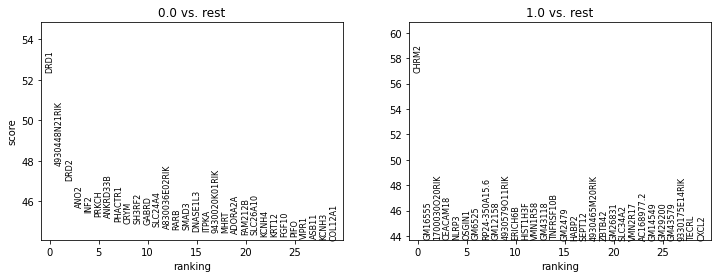

In [66]:
sc.tl.rank_genes_groups(adata, 'is_clz_selective', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

In [67]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_selective')

ValueError: adata.var_names contains duplicated items
Please rename these var names first for example using `adata.var_names_make_unique()`

In [59]:
sc.pl.violin(adata, "cAMP_CLOZAPINE", groupby='leiden')

AttributeError: 'function' object has no attribute '_sanitize'

In [68]:
sc.pl.violin(adata, "cAMP_OLANZAPINE", groupby='leiden')

ValueError: adata.var_names contains duplicated items
Please rename these var names first for example using `adata.var_names_make_unique()`

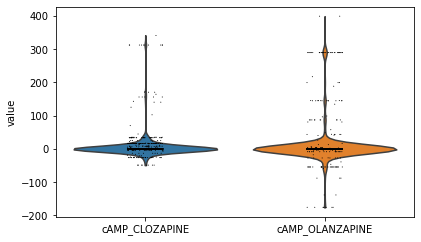

In [63]:
sc.pl.violin(adata[adata.obs["leiden"]==5],[ "cAMP_CLOZAPINE", "cAMP_OLANZAPINE"])

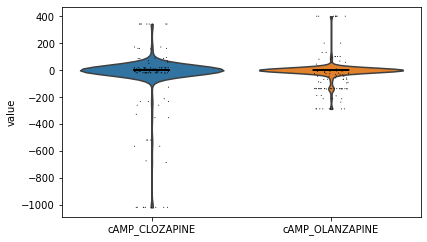

In [64]:
sc.pl.violin(adata[adata.obs["leiden"]==11],[ "cAMP_CLOZAPINE", "cAMP_OLANZAPINE"])

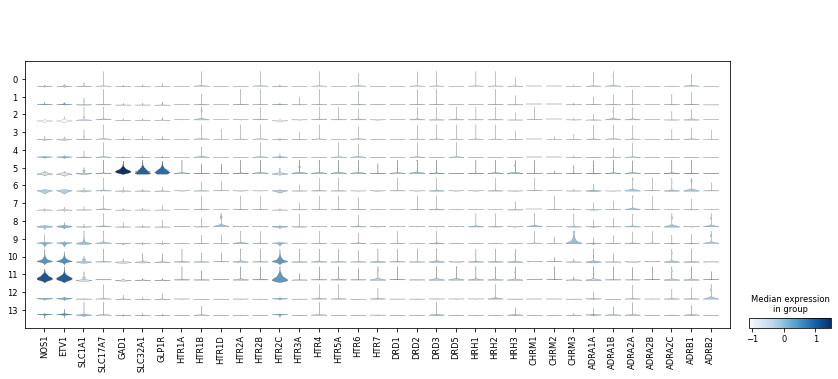

In [58]:
sc.pl.stacked_violin(adata, markers, groupby='leiden', rotation=90)